# IMPORT THE LIBRARY

In [307]:
import glob
import keras
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, BatchNormalization, Reshape, LeakyReLU, Activation

# A FEW SAMPLE OF THE DATASET

In [308]:
from tqdm import tqdm

In [309]:
def get_a_few_image(batch=64, num_image=8):
    image_ids = glob.glob('../../img_align_celeba/img_align_celeba/*')[:num_image]
    crop = (30, 55, 150, 175)
    images = [np.array((Image.open(i).crop(crop)).resize((64,64))) for i in tqdm(image_ids)]
    plt.figure(figsize=(14, 14))
    for j in tqdm(range(num_image)):
        plt.subplot(1, num_image, j+1)
        plt.imshow(images[j])
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.03s/it]


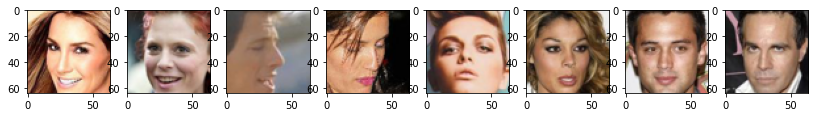

In [310]:
get_a_few_image()

#  IMPORTING AND RESIZING ALL THE IMAGES OF THE DATASET

In [350]:
image_ids = glob.glob('../../img_align_celeba/img_align_celeba/*')[:10000]
def import_image(batch):
    batch_ids = np.random.choice(image_ids, batch)
    crop = (30, 55, 150, 175)
    images = [np.array((Image.open(i).crop(crop)).resize((64,64))) for i in _ids]

    for i in range(len(images)):
        images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))
        images[i] = images[i]*2-1

    images = np.array(images)  

In [354]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    
    for ax, img in zip(axes.flatten(), samples[epoch]):
        
        ax.axis('off')
        # img = (((img+1)/2)*255).astype(np.uint8)
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        im = ax.imshow(img)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [351]:
def get_generator():
    
    inp = Input((512,))
        
    x = Dense(8192)(inp)
    x = Reshape((4,4,512))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
        
    x = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)        
    x = LeakyReLU(0.2)(x)        
    
    x = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)        
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)        
    x = LeakyReLU(0.2)(x)   
        
    x = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same')(x)
    out = Activation('tanh')(x)
        
    model = Model(inp, out)    
        
    return model

In [352]:
def get_discriminator():
    
    inp = Input((64,64,3))

    x = Conv2D(28, kernel_size=5, strides=2, padding='same')(inp)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(256, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Reshape((4096,))(x)
    x = Dense(1)(x)
    out = Activation('sigmoid')(x)
    
    model = Model(inp, out)    
        
    return model

In [353]:
def train(batch, epochs):
    
    generator = get_generator()
    discriminator = get_discriminator()
    
    adam_generator = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    adam_discriminator = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_discriminator, metrics=['accuracy'])
    generator.compile(loss='binary_crossentropy', optimizer=adam_generator, metrics=['accuracy'])  
    
    noise = Input((512,))
    z = discriminator(generator(noise))
    discriminator.trainable = False
    combined = Model(noise, z)
    combined.compile(loss='binary_crossentropy', optimizer=adam_generator, metrics=['accuracy'])
    discriminator.trainable = True

    print_every = 50
    no_batch = 1000//batch

    for e in range(epochs): 
    
        for i in range(no_batch):
            
            noise = np.random.uniform(-1, 1, size=(batch, 512))
            real_images = import_image(batch)
            fake_images = generator.predict(noise)
            
            images = np.concatenate((real_images, fake_images))
            labels = np.concatenate((np.ones((batch,1)), np.zeros((batch,1))))
        
            discriminator.train_on_batch(images, labels)
            discriminator.trainable = False    
            combined.train_on_batch(noise, np.ones((batch,1)))
            discriminator.trainable = True
            
            plt.subplot(1, 2, 1)
            plt.imshow(real_images[0])
            plt.subplot(1, 2, 2)
            plt.imshow(images[0])
            plt.show()
            if i%print_every == 0:
                print("epochs: %d/%d batchs: %d/%d" %((e+1),epochs,(i+1),no_batch))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 123.75it/s]


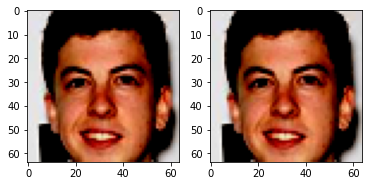

epochs: 1/1 batchs: 1/7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:03<00:00, 36.78it/s]


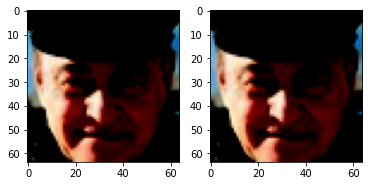

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 125.66it/s]


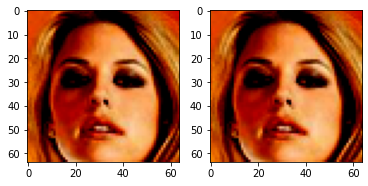

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 117.69it/s]


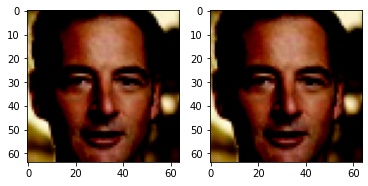

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 136.70it/s]


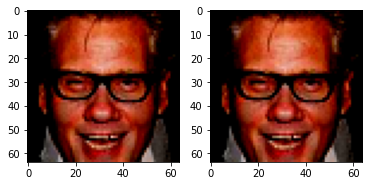

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 84.20it/s]


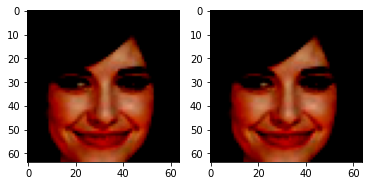

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 68.28it/s]


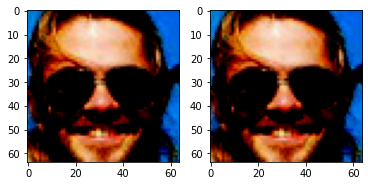

In [349]:
train(128, 1)

In [345]:
generator = get_generator()
a = generator.predict(np.random.uniform(-1, 1, size=(1,512)))
a = (a[0])*127.5 + 1


In [ ]:
# a = a+0.5
plt.imshow(a)
plt.show()

In [ ]:
plt.imshow(a[0])

In [179]:
# building the graph

tf.reset_default_graph()

input_real, input_noise = inputs(input_shape, noise_size)

gen_noise, gen_logits = generator(input_noise)

dis_out_real, dis_logits_real = discriminator(input_real)
dis_out_fake, dis_logits_fake = discriminator(gen_noise, reuse=True)

AttributeError: module 'keras.api._v1.keras.layers' has no attribute 'dense'

In [90]:
# defining losses

shape = dis_logits_real

dis_loss_real = reduce_mean(loss(logits=dis_logits_real, labels=tf.ones_like(shape*smooth)))

dis_loss_fake = reduce_mean(loss(logits=dis_logits_fake, labels=tf.zeros_like(shape)))                             

gen_loss = reduce_mean(loss(logits=dis_logits_fake, labels=tf.ones_like(shape*smooth)))

dis_loss = dis_loss_real + dis_loss_fake 

NameError: name 'dis_logits_real' is not defined

In [ ]:
# defining optimizers

total_vars = tf.trainable_variables()

dis_vars = [var for var in total_vars if var.name[0] == 'd']
gen_vars = [var for var in total_vars if var.name[0] == 'g']
 
dis_opt = adam(learning_rate=learning_rate, beta1=beta1).minimize(dis_loss, var_list=dis_vars)
gen_opt = adam(learning_rate=learning_rate, beta1=beta1).minimize(gen_loss, var_list=gen_vars)

In [ ]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    
    for ax, img in zip(axes.flatten(), samples[epoch]):
        
        ax.axis('off')
        # img = (((img+1)/2)*255).astype(np.uint8)
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        im = ax.imshow(img)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [ ]:
batch_size = 128
epochs = 10
iters = len(image_ids)//batch_size
saver = tf.train.Saver(var_list = gen_vars)

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
                
        for i in range(iters-1):
            
            batch_images = images[i*batch_size:(i+1)*batch_size]
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            sess.run(dis_opt, feed_dict={input_real: batch_images, input_noise: batch_noise})
            sess.run(gen_opt, feed_dict={input_real: batch_images, input_noise: batch_noise})
            
            if i%50 == 0:
                print("Epoch {}/{}...".format(e+1, epochs), "Batch No {}/{}".format(i+1, iters))
                
        loss_dis = sess.run(dis_loss, {input_noise: batch_noise, input_real: batch_images})
        loss_gen = gen_loss.eval({input_real: batch_images, input_noise: batch_noise})
            
        print("Epoch {}/{}...".format(e+1, epochs),"Discriminator Loss: {:.4f}...".format(loss_dis),
              "Generator Loss: {:.4f}".format(loss_gen))      
        
        sample_noise = np.random.uniform(-1, 1, size=(8, noise_size))
        gen_samples = sess.run(generator(input_noise, reuse=True, alpha=alpha),
                               feed_dict={input_noise: sample_noise})

        view_samples(-1, gen_samples, 2, 4, (10,5))
        plt.show()
        saver.save(sess, './checkpoints/generator.ckpt')